# Environment Setup

In [ ]:
# Data Formatting
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import datetime

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from scipy.stats import boxcox
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score

# Regressors
from sklearn.svm import SVR

# Deep Learning

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


# Data Processing

## Data Formatting

In [ ]:
# Read in data
df_train = pd.read_csv('train_data.csv')                #2000-2012
df_validation = pd.read_csv('validation_data.csv')      #2013-2016
df_test = pd.read_csv('test_data.csv')                  #2017-2020

# Converting dates into months, dates are non-numeric
df_train['date'] = pd.to_datetime(df_train['date'])
df_validation['date'] = pd.to_datetime(df_validation['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

df_train['month'] = df_train['date'].dt.month
df_validation['month'] = df_validation['date'].dt.month
df_test['month'] = df_test['date'].dt.month

In [ ]:
# Initialize variables
X_train = df_train.drop(columns=['score', 'D', 'date'])
y_train = df_train[['score']]

X_validation = df_validation.drop(columns=['score', 'D', 'date'])
y_validation = df_validation[['score']]

X_test = df_test.drop(columns=['score', 'D', 'date'])
y_test = df_test[['score']]

In [ ]:
# Standardize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
x_test_scaled = scaler.transform(X_test)

## Feature Selection

### Heat Map

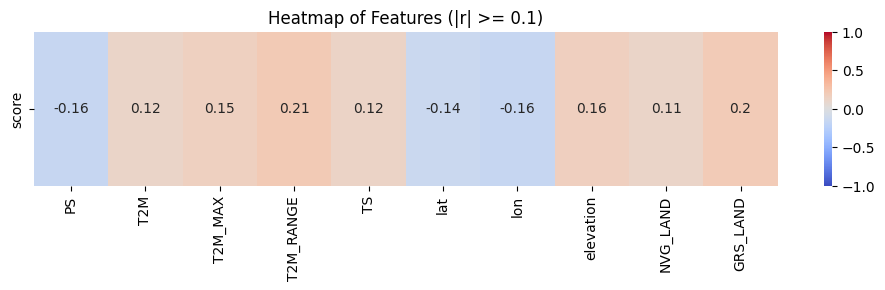

In [ ]:
# Combine selected features with target variable 'D'
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_df['score'] = y_train

# Calculate the correlation matrix between features and the target 'score'
correlation_with_target = X_train_df.corr()['score'].drop('score')

# Filter features with absolute correlation >= 0.1
filtered_correlation = correlation_with_target[correlation_with_target.abs() >= 0.1]

# Reshape the filtered correlations to a DataFrame
filtered_correlation_df = filtered_correlation.to_frame().transpose()

# Plotting the heatmap for the filtered correlations
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Features (|r| >= 0.1)')
plt.show()


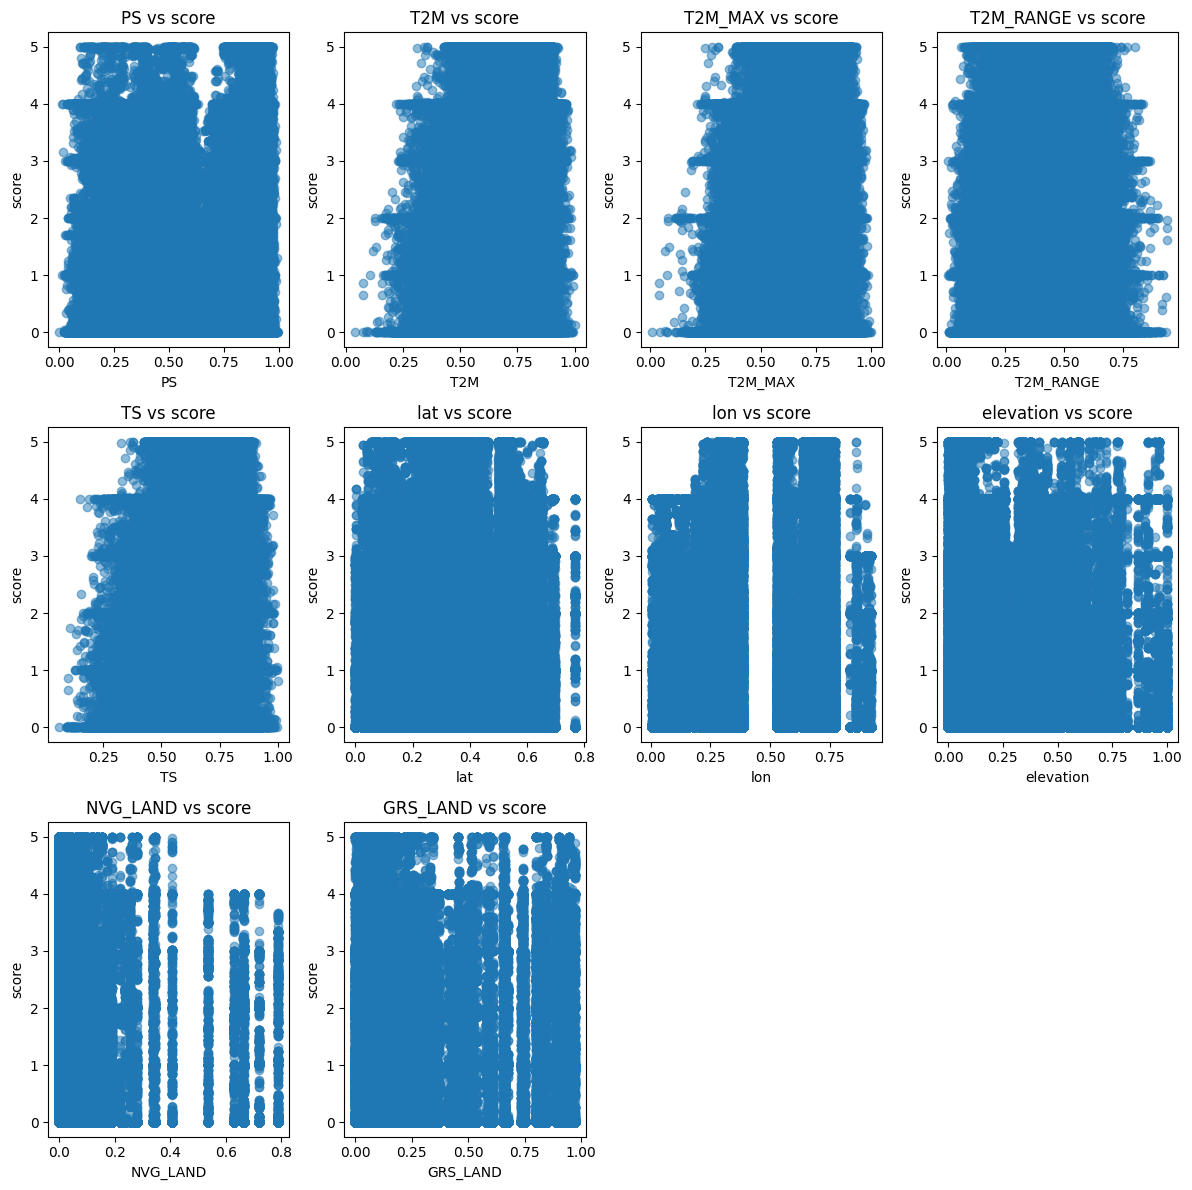

In [ ]:
# Number of data points to display (first sixth of the data)
subset_length = len(X_train_df) // 6

# Plot scatter plots for each feature vs y ('score') for the first sixth of the data
plt.figure(figsize=(12, 12))

for i, feature in enumerate(filtered_correlation_df.columns):
    plt.subplot(3, 4, i+1)
    # Scatter plot using only the first sixth of the data
    plt.scatter(X_train_df[feature].iloc[:subset_length], y_train.iloc[:subset_length], alpha=0.5)
    plt.title(f'{feature} vs score')
    plt.xlabel(feature)
    plt.ylabel('score')

plt.tight_layout()
plt.show()


### Lasso

In [ ]:
lasso_model = LassoCV(alphas=[1e-4], cv=5, random_state=42).fit(X_train_scaled, y_train)

# If X_train_scaled is a NumPy array, use the original DataFrame X_train for feature names
feature_names = X_train.columns  # Ensure this refers to the DataFrame version of the features

# Extract Lasso coefficients
lasso_coefficients = lasso_model.coef_

# Create a DataFrame with feature names and their corresponding Lasso coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

# Sort by absolute value of the coefficients and return the top features
top_features = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index).head(8)
print(top_features)

/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.1761494621169, tolerance: 237.8696285093234
  model = cd_fast.enet_coordinate_descent_gram(
/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.0528575689532, tolerance: 273.96453527883364
  model = cd_fast.enet_coordinate_descent_gram(
/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/sklearn/linear

         Feature  Coefficient
7         T2MDEW    -5.459384
12            TS     3.516210
9        T2M_MAX     3.221941
6            T2M    -2.908862
10       T2M_MIN     2.089860
2           fips     1.463638
0   Unnamed: 0.1    -1.398925
3        PRECTOT     1.247092


/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.101e+02, tolerance: 3.231e+02
  model = cd_fast.enet_coordinate_descent(


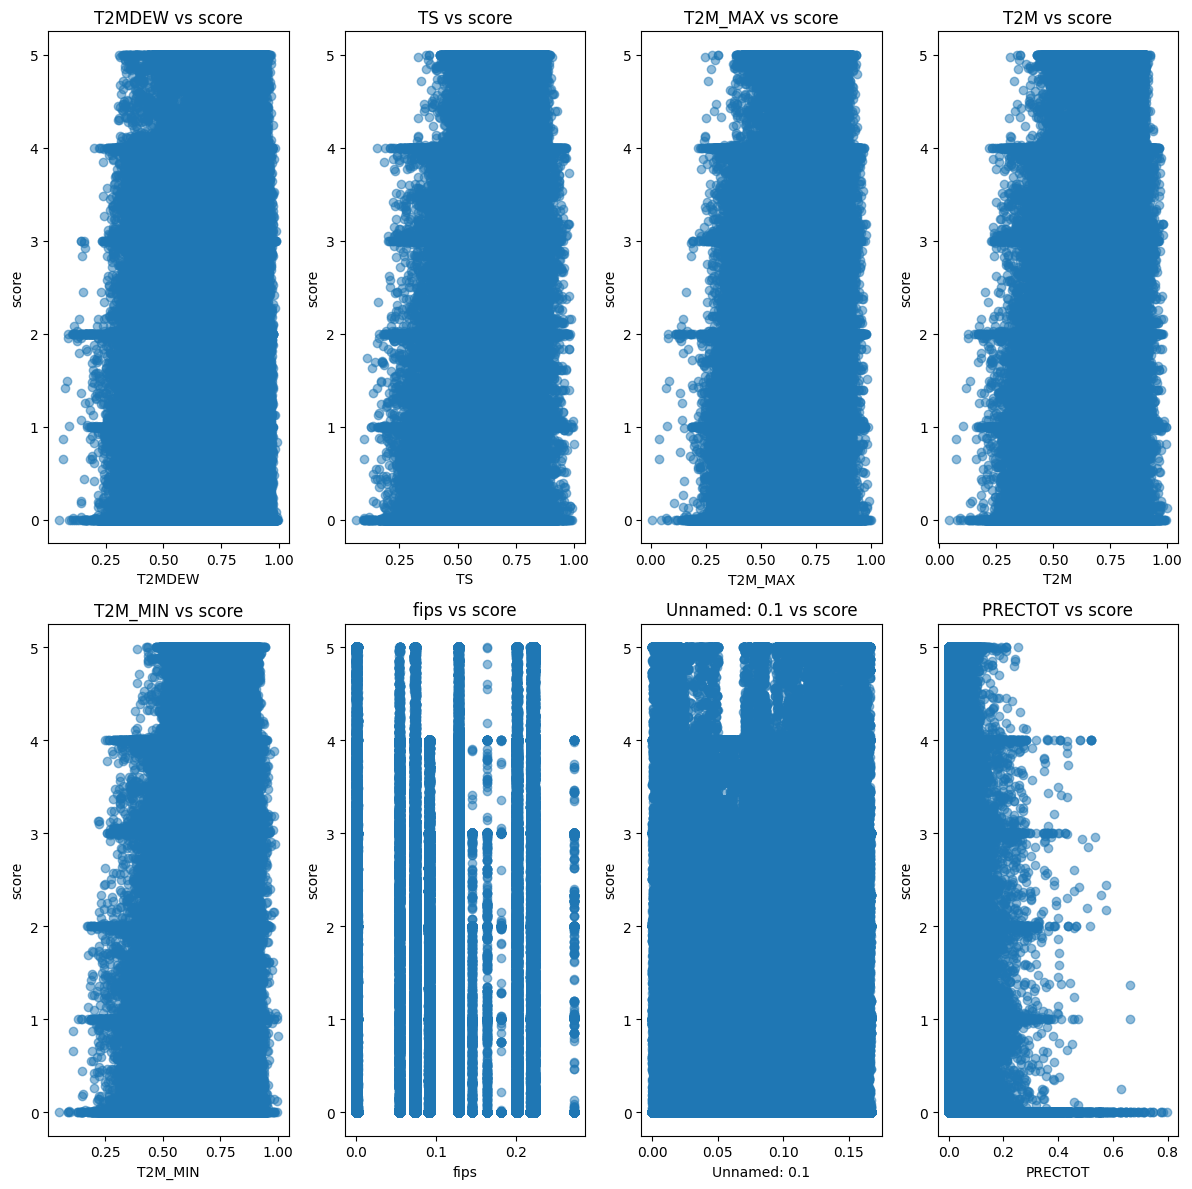

In [ ]:
# Number of data points to display (first sixth of the data)
subset_length = len(X_train_df) // 6

# Plot scatter plots for each feature vs y ('score') for the first sixth of the data
plt.figure(figsize=(12, 12))

for i, feature in enumerate(top_features['Feature']):
    plt.subplot(2, 4, i+1)
    # Scatter plot using only the first sixth of the data
    plt.scatter(X_train_df[feature].iloc[:subset_length], y_train.iloc[:subset_length], alpha=0.5)
    plt.title(f'{feature} vs score')
    plt.xlabel(feature)
    plt.ylabel('score')

plt.tight_layout()
plt.show()

## Data Transforms

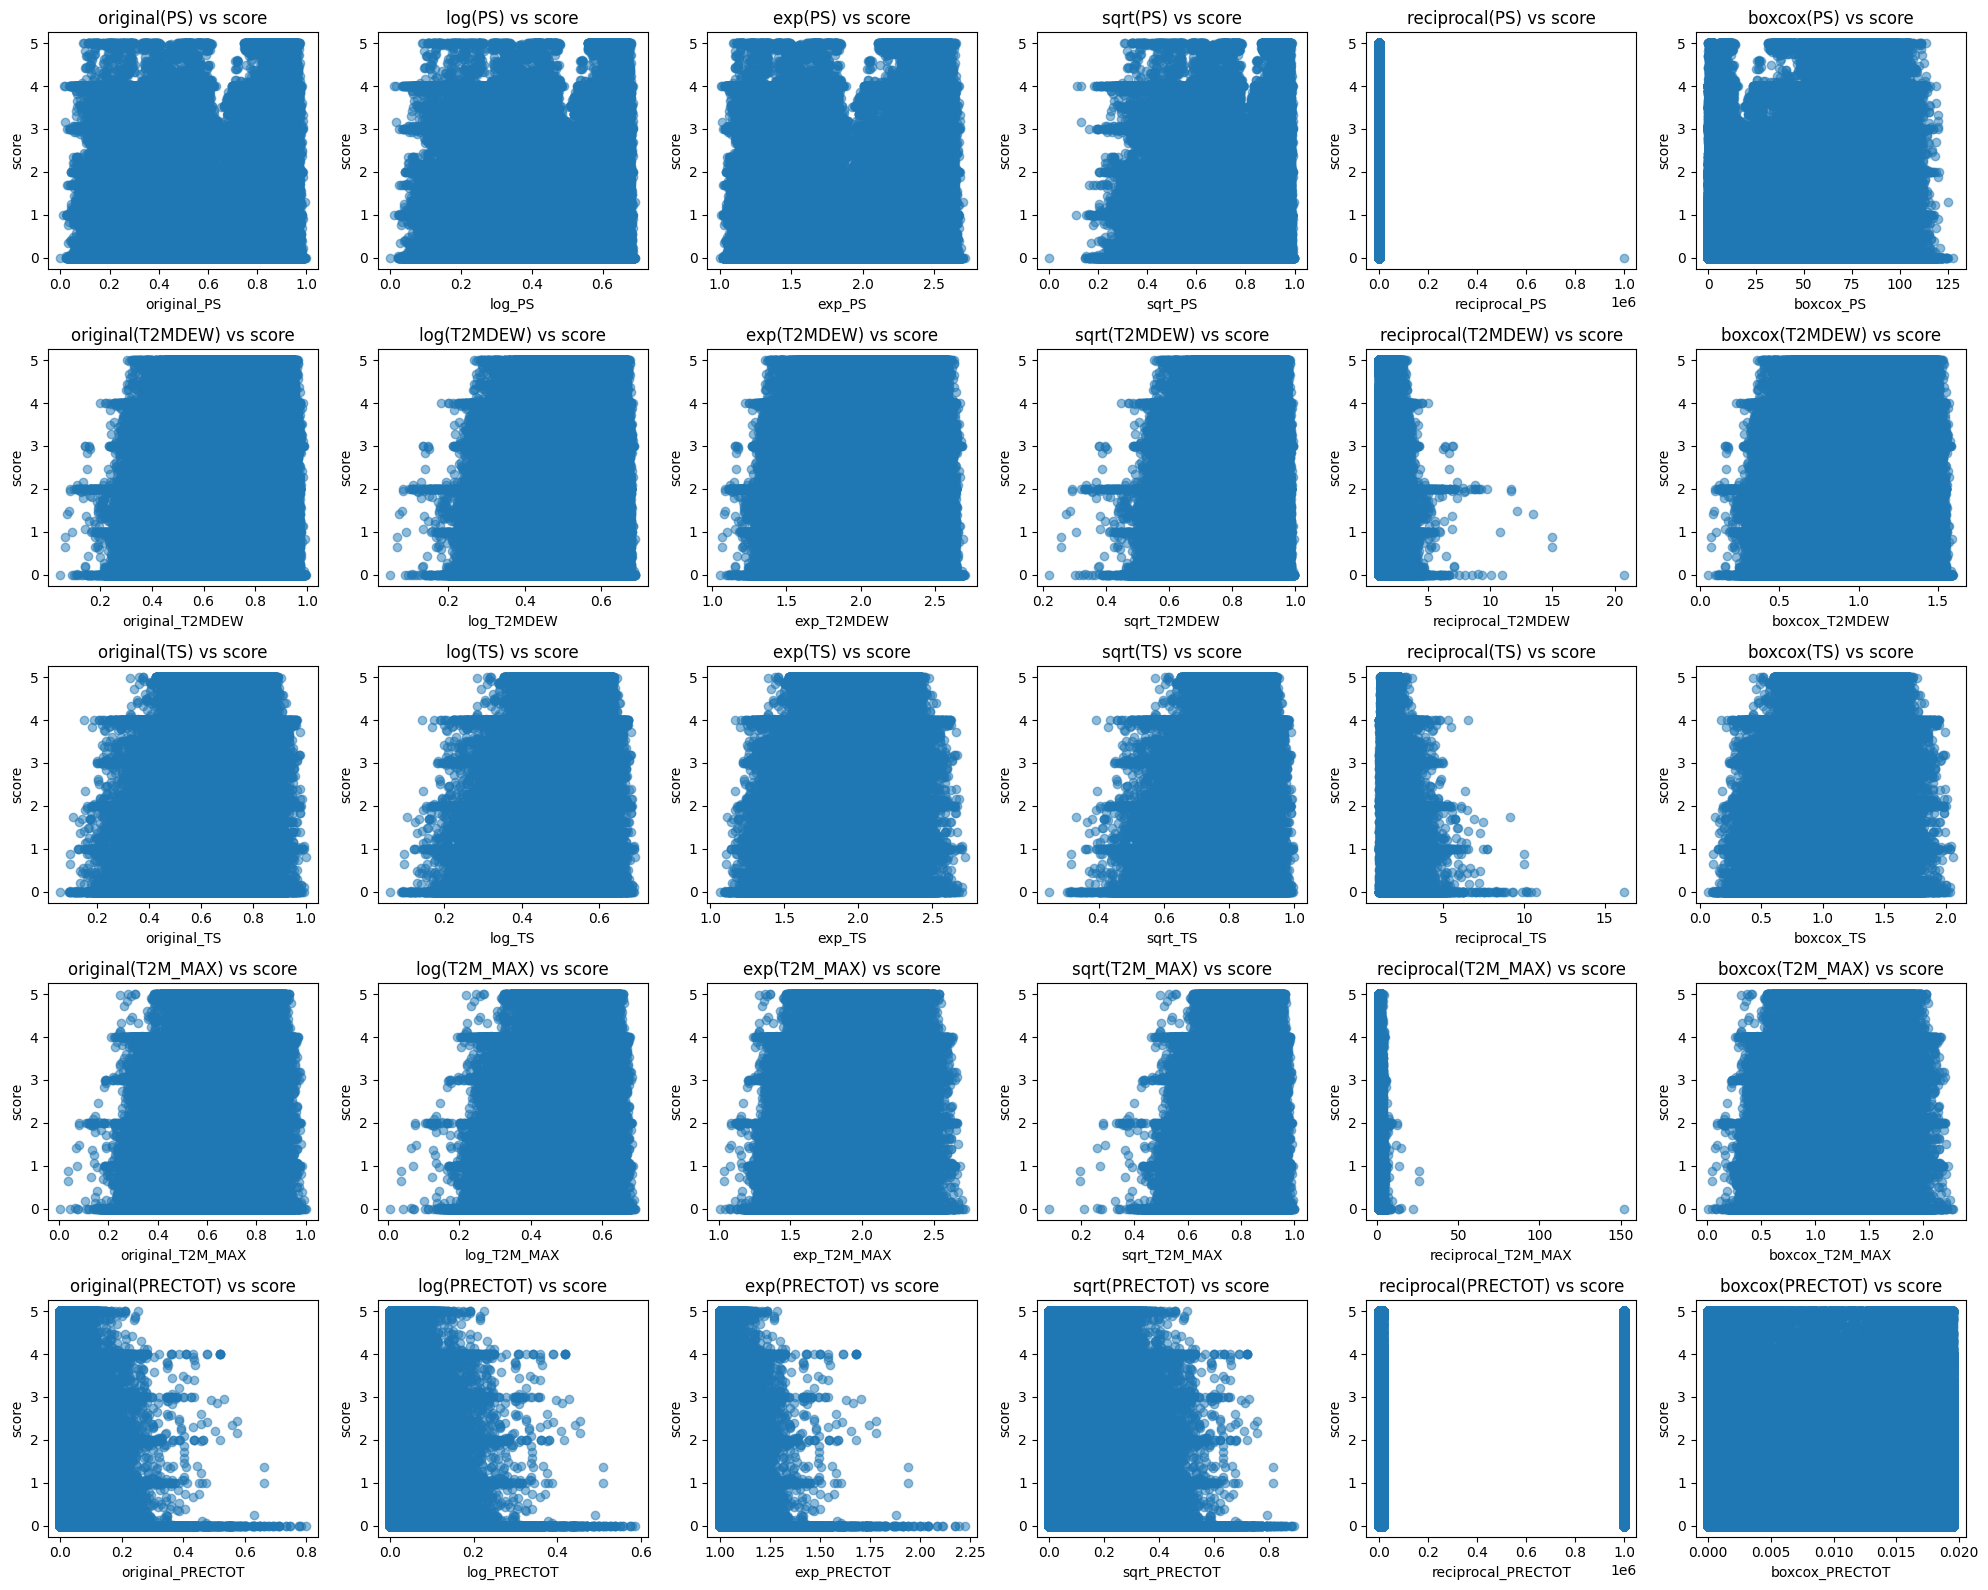

In [ ]:
# Combine selected features with target variable 'score'
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_df['score'] = y_train

# Select the features for transformation
selected_features = ['PS', 'T2MDEW', 'TS', 'T2M_MAX', 'PRECTOT']

# Define transformations
def apply_transformations(df, features):
    transformed_data = {}

    for feature in features:
        # Original feature (no transformation)
        transformed_data[f'original_{feature}'] = df[feature]

        # Log transform (shift data to avoid log(0))
        transformed_data[f'log_{feature}'] = np.log(df[feature] + 1)

        # Exponential transform
        transformed_data[f'exp_{feature}'] = np.exp(df[feature])

        # Square root transform (shift data to avoid sqrt(negative))
        transformed_data[f'sqrt_{feature}'] = np.sqrt(df[feature].clip(lower=0))

        # Reciprocal transform (avoid divide by zero)
        transformed_data[f'reciprocal_{feature}'] = 1 / (df[feature] + 1e-6)

        # Box-Cox transform (shift data to positive and apply Box-Cox)
        if (df[feature] > 0).all():  # Box-Cox requires positive data
            transformed_data[f'boxcox_{feature}'], _ = boxcox(df[feature])
        else:
            shifted_feature = df[feature] - df[feature].min() + 1  # Shift to positive values
            transformed_data[f'boxcox_{feature}'], _ = boxcox(shifted_feature)

    return pd.DataFrame(transformed_data)

# Apply transformations
transformed_df = apply_transformations(X_train_df, selected_features)

# Number of data points to display (first sixth of the data)
subset_length = len(X_train_df) // 6
transformed_df = transformed_df.iloc[:subset_length]
score_subset = X_train_df['score'].iloc[:subset_length]

# Plotting original and transformed features vs 'score'
plt.figure(figsize=(20, 16))
plot_num = 1

for feature in selected_features:
    # Plot for original feature and each transformation
    for transform in ['original', 'log', 'exp', 'sqrt', 'reciprocal', 'boxcox']:
        transformed_feature = f'{transform}_{feature}'
        plt.subplot(len(selected_features), 6, plot_num)
        plt.scatter(transformed_df[transformed_feature], score_subset, alpha=0.5)
        plt.title(f'{transform}({feature}) vs score')
        plt.xlabel(transformed_feature)
        plt.ylabel('score')
        plot_num += 1

plt.tight_layout()
plt.show()


## PCA

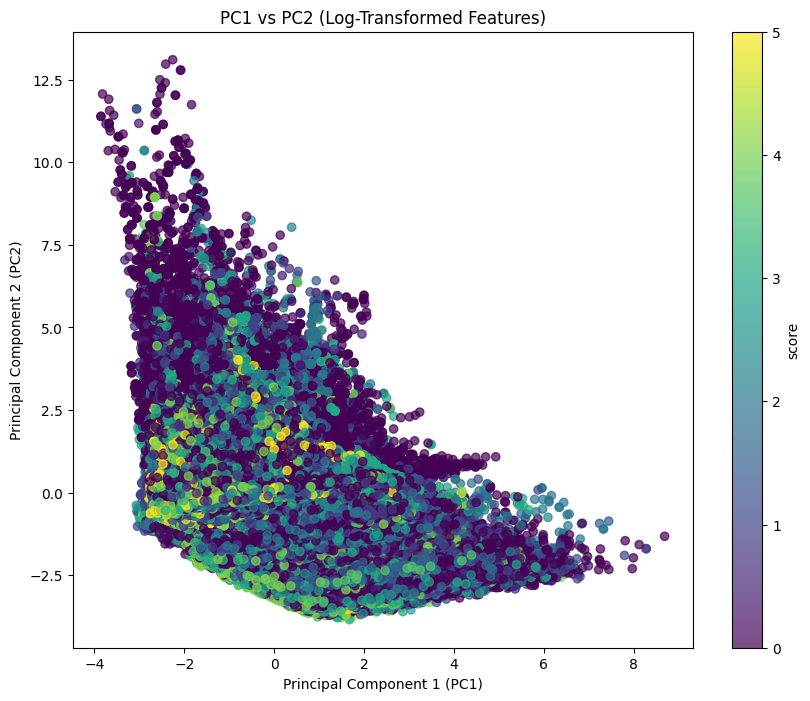

In [ ]:
# Combine selected features with target variable 'score'
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_df['score'] = y_train

# Select the features for transformation
selected_features = ['PS', 'T2MDEW', 'TS', 'T2M_MAX', 'PRECTOT']

# Apply log transform to the selected features (shift to avoid log(0))
X_log_transformed = np.log(X_train_df[selected_features] + 1)

# Standardize the log-transformed data before applying PCA
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log_transformed)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_log_scaled)

# Number of data points to display (first sixth of the data)
subset_length = len(X_train_df) // 6
X_pca_subset = X_pca[:subset_length]
score_subset = X_train_df['score'].iloc[:subset_length]

# Plotting PC1 vs PC2, colored by score
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], c=score_subset, cmap='viridis', alpha=0.7)
plt.title('PC1 vs PC2 (Log-Transformed Features)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(scatter, label='score')  # Add a colorbar to show score values
plt.show()


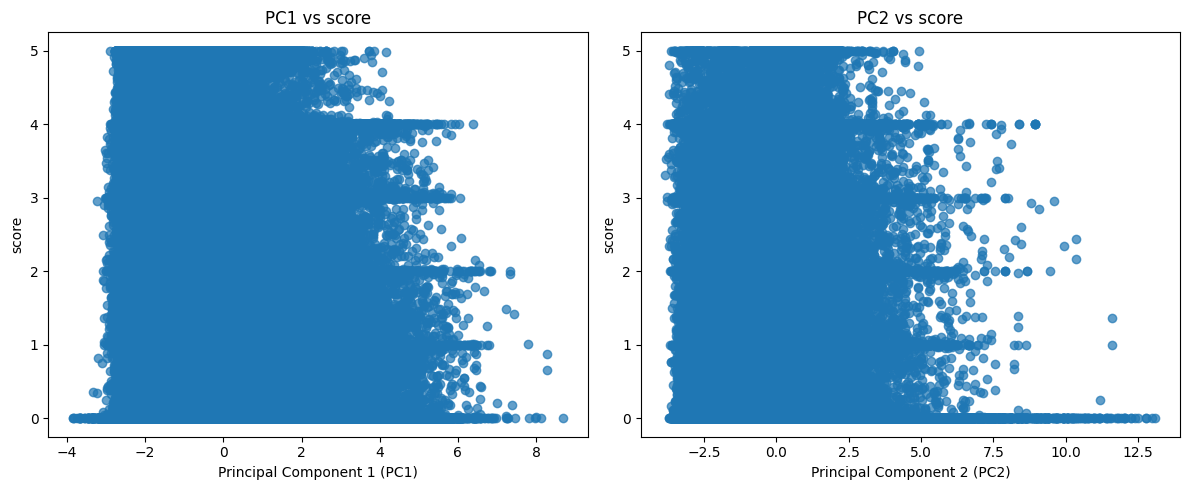

In [ ]:
# Plot PC1 vs score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca_subset[:, 0], score_subset, alpha=0.7)
plt.title('PC1 vs score')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('score')

# Plot PC2 vs score
plt.subplot(1, 2, 2)
plt.scatter(X_pca_subset[:, 1], score_subset, alpha=0.7)
plt.title('PC2 vs score')
plt.xlabel('Principal Component 2 (PC2)')
plt.ylabel('score')

plt.tight_layout()
plt.show()

# Regression Models

## Support Vector Machine (SVM) Regression

SVM Regression, also known as Support Vector Regression (SVR), is a supervised learning algorithm derived from the Support Vector Machine (SVM) framework, originally designed for classification. In SVR, the goal is to predict a continuous output by finding a function that deviates from the actual values by at most a specified margin (epsilon), while also penalizing deviations larger than this margin.

### TL;DR
SVM Regression (SVR) is an extension of SVM for continuous data, aiming to fit a function within a defined margin (epsilon) while minimizing the error. It’s useful for regression problems with non-linear relationships and when controlling the margin of error is important.

### Math Behind SVM Regression

**Objective Function**
The core idea is to minimize the error while balancing model complexity. The function to be optimized is:

$
\frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
$

Where:
- $ w $ is the weight vector.
- $ C $ is the regularization parameter (controls trade-off between error and margin).
- $ \xi_i $ and $ \xi_i^* $ are slack variables representing deviations beyond the margin.
- $ \|w\|^2 $ is the regularization term that ensures a smooth and generalized function.

**Constraints**
The algorithm seeks to fit the function:

$
y = w^T x + b
$

Subject to:
$
y_i - (w^T x_i + b) \leq \epsilon + \xi_i
$
$
(w^T x_i + b) - y_i \leq \epsilon + \xi_i^*
$

Where:
- $ \epsilon $ defines the margin of tolerance.
- $ \xi_i, \xi_i^* \geq 0 $ are slack variables that allow for some flexibility in case data points lie outside the epsilon margin.

**Kernel Trick**
Similar to SVM classification, SVR can use kernels (linear, polynomial, RBF, etc.) to model non-linear relationships by mapping input data into a higher-dimensional space where a linear function can be applied.

**When to Use SVM Regression**

1. When you want to minimize error within a defined margin: SVM regression is good when you want to control how much error is acceptable.
2. For non-linear data: SVR is flexible and can handle non-linearity using the kernel trick.
3. Small or medium-sized datasets: SVR tends to perform well with fewer samples, though computational complexity increases with larger datasets.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# Train the SVM Regressor using the PCA components
svm_regressor = SVR(kernel='rbf')  # Using radial basis function (rbf) kernel
svm_regressor.fit(X_pca_subset, score_subset)

# Make predictions
score_pred = svm_regressor.predict(X_pca_subset)

# Calculate R² score
r2 = r2_score(score_subset, score_pred)
print(f'R² Score: {r2:.4f}')

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(score_subset, score_pred, alpha=0.7, color='b')
plt.plot([min(score_subset), max(score_subset)], [min(score_subset), max(score_subset)], color='red', linestyle='--')
plt.title('Predicted vs Actual (Using PCA Components)')
plt.xlabel('Actual score')
plt.ylabel('Predicted score')
plt.show()


# Classification Models

In [ ]:
X_train_pca, X_test_pca, y_train_subset, y_test_subset = train_test_split(X_pca, y_train, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_pca, y_train_subset)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Print model performance
    print(f'--- {model_name} ---')
    print(f'Accuracy: {accuracy_score(y_test_subset, y_pred):.4f}')
    print(f'Classification Report:\n{classification_report(y_test_subset, y_pred)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test_subset, y_pred)}')
    print('\n')

## Decision Tree

In [ ]:
# Plot predicted vs actual for one of the classifiers (e.g., Logistic Regression)
model = models['Decision Tree']
y_pred = model.predict(X_test_pca)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_subset, y_pred, alpha=0.7, color='b')
plt.title('Predicted vs Actual (Decision Tree)')
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.show()

## Random Forest

In [ ]:
# Plot predicted vs actual for one of the classifiers (e.g., Logistic Regression)
model = models['Random Forest']
y_pred = model.predict(X_test_pca)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_subset, y_pred, alpha=0.7, color='b')
plt.title('Predicted vs Actual (Random Forest)')
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.show()

## SVM

In [ ]:
# Plot predicted vs actual for one of the classifiers (e.g., Logistic Regression)
model = models['SVM']
y_pred = model.predict(X_test_pca)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_subset, y_pred, alpha=0.7, color='b')
plt.title('Predicted vs Actual (SVM)')
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.show()

# Clustering

In [ ]:
models = {
    'K-Means': KMeans(n_clusters=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Gaussian Mixture Model (GMM)': GaussianMixture(n_components=5, random_state=42)
}

# Fit and predict clusters for models that don't require fitting the training target
for model_name, model in models.items():
    if model_name == 'K-Nearest Neighbors':
        # For KNN, we need target labels, so let's assume we're using cluster centers from K-Means
        kmeans = KMeans(n_clusters=5, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        model.fit(X_pca, labels)
        y_pred = model.predict(X_pca)
    else:
        y_pred = model.fit_predict(X_pca)

    # Calculate silhouette score for clustering quality
    if model_name != 'K-Nearest Neighbors':  # Silhouette doesn't apply to KNN as it requires labeled data
        silhouette_avg = silhouette_score(X_pca, y_pred)
        print(f'{model_name} Silhouette Score: {silhouette_avg:.4f}')

    # Plotting the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    plt.title(f'{model_name} Clustering (PC1 vs PC2)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()